# Homework 6: Text classification

In this homework, you need to build a text classifier and participate in a Kaggle competition!

First, you need to create a good baseline model, and then try to improve it while competing with other participants.

Competition link: https://www.kaggle.com/c/avito-category-prediction/overview
You can download the dataset for the homework on the competition page.
To ensure your participation is counted, make sure your name on the Leaderboard is in the format: "First Last group_number".

Grading:

The homework is graded as usual. Points are indicated next to the tasks.

Bonus points are awarded for the competition as follows:
If you surpass baseline_2 on the private leaderboard, your grade will be

10 - 10 * (i - 1) / M

where M is the number of students who participated in the competition;
i is the student's position (starting from 1) in the private leaderboard among all such students.

Rules:

* Homework is graded for 10 points.
* Plagiarism is not allowed. In case of plagiarism, a grade of 0 will be assigned to all involved participants, even if it can be determined who copied from whom.
* Try to make the code as optimal as possible. In particular, using loops where operations can be performed using library tools taught in the course will be penalized.
* Within 3 days after the competition ends, you must submit the code that reproduces the answers for the submission that appears on the private leaderboard in the corresponding task on anytask. If the code reproducing the result is not submitted on time, the student will be given a grade of 0 for the competition. If not stated otherwise, using any external data in the competition is 'forbidden'. External data refers to labeled data where the labels directly relate to the task at hand. Roughly speaking, a collection of Wikipedia texts is not considered external data.


We will be working with the 'Avito' ad dataset. We will have to predict the category of the ad based on the title and text of the ad.

title - the title of the ad

description - description of the ad

Category_name - category in text format

Category - numeric category

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


## Task 1 (0.5 points)

Display information about data gaps on the screen. If there are gaps, fill them in with an empty line.

In [5]:
train.isnull().sum()

title            0
description      2
Category_name    0
Category         0
dtype: int64

In [37]:
train['description'].fillna('', axis=0, inplace=True)

In [7]:
test.isnull().sum()

title          0
description    1
itemid         0
dtype: int64

In [38]:
test['description'].fillna('', axis=0, inplace=True)

## Task 2 (0.5 points)
Combine the title and description into a single row and put the result in a separate column. This way we will work with one text, not two.

In [39]:
train['concatenated'] = train['title'] + '.' + ' ' + train['description']

In [10]:
train['concatenated'][0]

'Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год. Комплект ЭБУ (мозги, компьютер мотора, двигателя, коммутатор). Электронный блок управления двигателем (компьютер мотора) для Рено Kangoo (Канго Кангу), Меган, Сценик, Laguna (Лагуна), Clio (Клио), Nissan Micra (Ниссан Микра) и другие Рено Ниссан 1,5 дизель с топливной аппаратурой Делфи. Б.У. Оригинал, отличное состояние, проверенные с гарантией.\xa0/\n /\n\xa0............................................................................................./\n /\nНа все запчасти предоставляется\xa0ГАРАНТИЯ, возможна\xa0установка.\xa0Более подробно — в разделе «о компании». Мы дорожим своей репутацией и торгуем\xa0ТОЛЬКО ЛЕГАЛЬНЫМИ\xa0контрактными запчастями - на все детали в наличии таможенные документы. Все запчасти - от автомобилей\xa0БЕЗ ПРОБЕГА ПО РОССИИ.\xa0/\n /\n--- -------------------------------------------------------------------------------------------------/\n /\nОтправляем в другие регионы Таможенного Союза транспортной компани

In [40]:
test['concatenated'] = test['title'] + '.' + ' ' + test['description']

In [12]:
test['concatenated'][0]

'Мастерка. Мастерка фирмы форвард. Белого цвета. В идеальном состоянии.'

## Task 3 (0.5 points)
Let's take a look at our data. Visualize (where explicitly requested) or output information about the following:

1. How many unique classes do you need to predict in total?
2. Build a bar chart of the distribution by class. Normalize the graph to see fractions rather than absolute values.
3. How big is the imbalance? Which class has the largest share in the sample (specify the class and share), which class has the smallest (specify the class and share).

In [13]:
print(len(train['Category'].unique()))

50


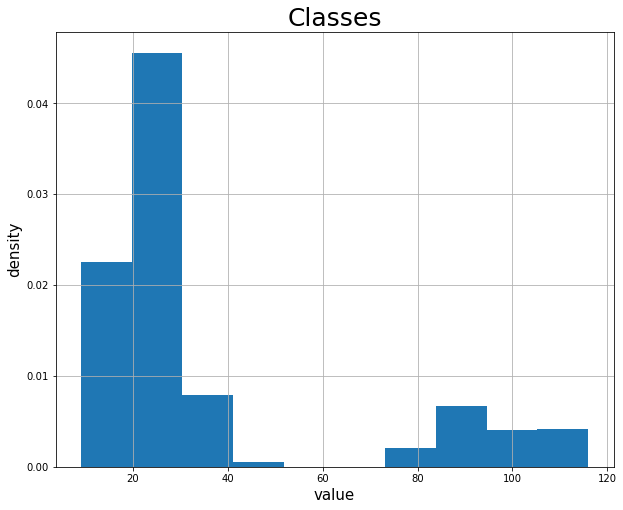

In [10]:
plt.figure(figsize=(10, 8))
plt.hist(train['Category'], density=True);
plt.title('Classes', fontsize=25)
plt.xlabel('value', fontname='density', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.grid()
plt.show()

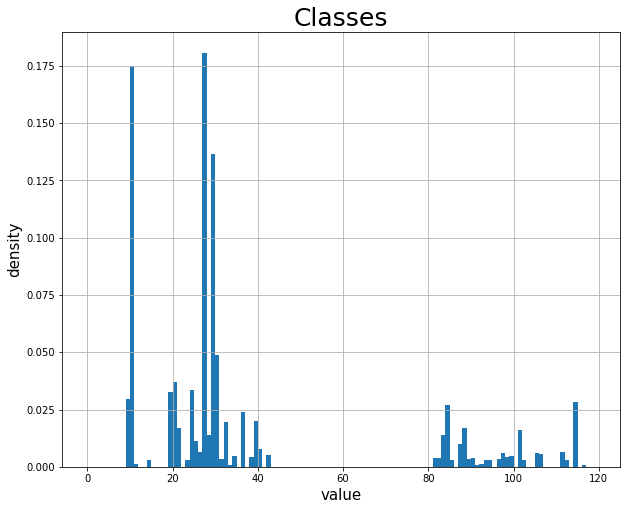

In [14]:
plt.figure(figsize=(10, 8))
y, x, _ = plt.hist(train['Category'], bins=range(120), density=True);
plt.title('Classes', fontsize=25)
plt.xlabel('value', fontname='density', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.grid()
plt.show()

As can be seen from the graph, the imbalance is quite large and the shares of certain classes reach about 17%, while many of the categories are either not represented or practically not represented.

In [26]:
print(y.argmax())
print(y.max())

11
0.1807067572782698


In [25]:
y = y[y>0]
print(y.argmin())
print(y.min())

29
3.8969854337769914e-05


## Task 4 (0.5 points)

Next, we will only work with the train part for now. We don't know the true values for the test part, and we'll only need them when we send the solution to Kaggle.

1. Pre-process the data (train part) using CountVectorizer.
2. What is the size of the matrix?


In [43]:
category_list = [row['concatenated'] for index,row in train.iterrows()]

In [45]:
vec = CountVectorizer()
X = vec.fit_transform(category_list)
vectorized = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [46]:
X.shape

(1000, 14266)

In [47]:
vectorized.shape

,00,000,0000,0000000416955,0000001145458,0000001160307,000руб,001,0012027,002,...,ясенево,ясень,ячеистый,ященко,ящик,ящика,ящиков,ящиком,яя,ёмкость
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Task 5 (0.5 points)

In the previous paragraph, you should have got a very large matrix. That's not the case.
If you look at the text, you will see that there are many special characters there.

Let's also look at the dictionary that resulted from building the CountVectorizer, which can be found in the _vocabulary field of an instance of this class.

1. Find in this dictionary all the words that begin with a number. How many such words were there?

2. Find all the words that begin with punctuation characters. How many such words were there?

In [52]:
# vec.vocabulary_.keys()

In [53]:
figures = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
words_with_figures = []
schet = 0
for key in vec.vocabulary_.keys():
    if key[0] in figures:
        words_with_figures.append(key)
        schet += 1
print(schet)

1195


In [54]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
punctuation = tw.tokenize(punctuation)

In [56]:
punctuation.extend(['.', ',', ':', ';', '-', '/', '+', '*', '(', ')', '&'])

In [58]:
schet = 0
words_with_punctuation = []
for key in vec.vocabulary_.keys():
    if key[0] in punctuation:
        words_with_punctuation.append(key)
        schet += 1
print(schet)

4


## Task 6 (2.5 points)

In scikit-learn, we can evaluate the matrix counting process through the CountVectorizer. CountVectorizer, like the other \_VectorizerMixin heirs, has a tokenizer and a preprocessor argument. preprocessor will be applied at the very beginning to each row of your dataset, while tokenizer must accept the row and return the tokens.
Let's write a custom tokenizer that will do everything we need.: 

0. Lowercase all letters.
1. Split the text into tokens using the word_tokenizer from the nltk package
2. Removes all tokens containing numerals and punctuation
3. Deletes all tokens listed in nltk.corpus.stopwords('english')
4. Perform stemming using SnowballStemmer

Demonstrate the operation of your function on the very first product description in the dataset.

Important: since the function will need to be run on a large body, think about an effective implementation. Try to solve the problem in the minimum number of cycles and copies.

The reference implementation on the author's computer ran for 230 seconds per 100k lines.

In [172]:
def preprocessor(text):
    text = text.lower()
    stop_words = words_with_punctuation + stopwords.words('russian') + words_with_figures
    tokens = word_tokenize(text)
    words = [i for i in tokens if not i in stop_words]
    stemmer = SnowballStemmer('russian')
    stemmed_words = [stemmer.stem(w) for w in words]
    return stemmed_words

In [174]:
# preprocessor(train['concatenated'][0])

## Task 7 (1 point)

1. Take a random 100k rows from the dataset. Use them to build a CountVectorizer using your tokenizer.
2. Divide the resulting matrix into train, test in a ratio of 4 to 1. Do not forget about the target variable.
3. Train the SGDClassifier on the resulting sample.
4. Calculate the accuracy metric

In [192]:
import random
random.seed(10)
a = random.sample(range(train.shape[0]), 100000)

In [193]:
train_100k = train.loc[a]

In [194]:
vec = CountVectorizer(tokenizer=preprocessor)
X = vec.fit_transform(train_100k['concatenated'])
vectorized = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [195]:
y = train_100k['Category']
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [196]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.83

## Task 8 (1 point)

1. Repeat task 7, but with the tf-idf vectorizer. How the quality has changed.
2. We can further reduce the size of our matrix by dropping df values close to one. Most likely, such words do not carry much information about the category, as they occur quite often. Limit the maximum df in the TfidfVectorizer parameters, set the upper bound to 0.9. How has the matrix size changed, how has the quality changed?

In [ ]:
tfidf_vec = TfidfVectorizer(tokenizer=preprocessor)
X = tfidf_vec.fit_transform(train_100k['concatenated'])
print(X.shape)
y = train_100k['Category']
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [198]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.84115

In [201]:
tfidf_vec = TfidfVectorizer(tokenizer=preprocessor, max_df=0.9)
X = tfidf_vec.fit_transform(train_100k['concatenated'])
print(X.shape)
y = train_100k['Category']
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

(100000, 230364)


In [202]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.8413

The size of the matrix has not changed

# Task 9 (1 point)
Another popular trick that will reduce the number of signs is called the hashing trick. Its essence is that we randomly group the features..... add them up! And then we delete the original signs. As a result, all our signs are just the sum of the original ones. It sounds weird, but it works great. Let's check out this trick in our setting.
Also, with this approach, you don't need to store a token->index dictionary, which is also sometimes useful.

1. Repeat task 7 with HashingVectorizer, specify the number of features equal to 30,000.
2. Which of the three approaches showed the highest result?

In [203]:
h_vec = HashingVectorizer(tokenizer=preprocessor, n_features=30000)
X = h_vec.fit_transform(train_100k['concatenated'])
y = train_100k['Category']
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [204]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.81605